In [1]:
from keras.utils import normalize
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

In [2]:
image_directory = 'data/patched_training_images/'
mask_directory = 'data/patched_training_masks/'

In [3]:
SIZE=256
image_dataset = []  
mask_dataset = []

In [4]:
images = os.listdir(image_directory)
for i, image_name in enumerate(images):    
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(image_directory+image_name, 0)
        image = Image.fromarray(image)
        #image = image.resize((SIZE, SIZE))
        image_dataset.append(np.array(image))

In [5]:
masks = os.listdir(mask_directory)
for i, image_name in enumerate(masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(mask_directory+image_name, 0)
        image = Image.fromarray(image)
        #image = image.resize((SIZE, SIZE))
        mask_dataset.append(np.array(image))

In [6]:
np.shape(mask_dataset)

(1980, 256, 256)

In [7]:
np.shape(image_dataset)

(1980, 256, 256)

In [8]:
image_dataset = np.expand_dims(normalize(np.array(image_dataset), axis=1),3)

In [9]:
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

In [10]:
image_dataset.shape

(1980, 256, 256, 1)

In [11]:
mask_dataset.shape

(1980, 256, 256, 1)

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.10, random_state = 42)

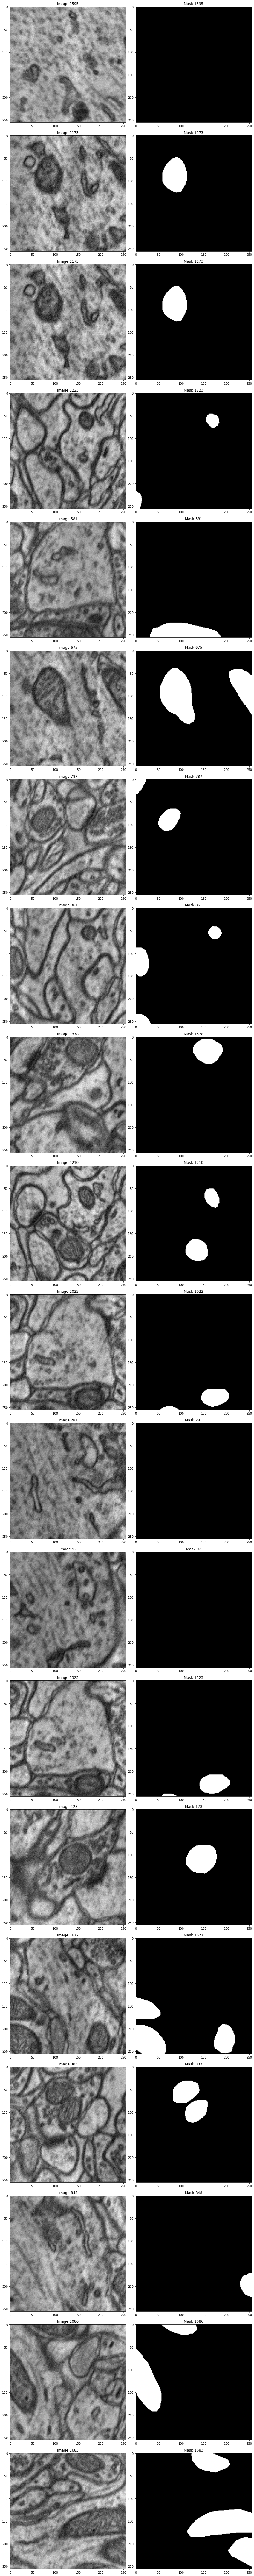

In [13]:
import random
import numpy as np
import matplotlib.pyplot as plt

num_images = 20  # Number of images to display

plt.figure(figsize=(12, 6 * num_images))

for i in range(num_images):
    image_number = random.randint(0, len(X_train))

    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(np.reshape(X_train[image_number], (256, 256)), cmap='gray')
    plt.title(f'Image {image_number}')

    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
    plt.title(f'Mask {image_number}')

plt.tight_layout()
plt.show()


In [21]:
######Define Model
import tensorflow as tf

class UNet(tf.keras.Model):
    def __init__(self, num_classes):
        super(UNet, self).__init__()

        self.down1 = DownsampleBlock(64, 2)
        self.down2 = DownsampleBlock(128, 2)
        self.down3 = DownsampleBlock(256, 2)
        self.down4 = DownsampleBlock(512, 2)

        self.bottom = ConvBlock(1024)

        self.up1 = UpsampleBlock(512, 2)
        self.up2 = UpsampleBlock(256, 2)
        self.up3 = UpsampleBlock(128, 2)
        self.up4 = UpsampleBlock(64, 2)

        self.out_conv = tf.keras.layers.Conv2D(num_classes, kernel_size=1, activation='sigmoid')

    def call(self, inputs, training=False):
        down1 = self.down1(inputs, training=training)
        down2 = self.down2(down1, training=training)
        down3 = self.down3(down2, training=training)
        down4 = self.down4(down3, training=training)

        bottom = self.bottom(down4, training=training)

        up1 = self.up1(bottom, down4, training=training)
        up2 = self.up2(up1, down3, training=training)
        up3 = self.up3(up2, down2, training=training)b
        up4 = self.up4(up3, down1, training=training)

        output = self.out_conv(up4)
        return output

class DownsampleBlock(tf.keras.layers.Layer):
    def __init__(self, filters, num_layers):
        super(DownsampleBlock, self).__init__()
        self.conv_layers = []
        self.maxpool = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(0.2)

        for _ in range(num_layers):
            self.conv_layers.append(ConvBlock(filters))

    def call(self, inputs, training=False):
        x = inputs

        for conv in self.conv_layers:
            x = conv(x, training=training)
            x = self.batchnorm(x, training=training)
            x = self.relu(x)
            x = self.dropout(x, training=training)

        x = self.maxpool(x)
        return x

class UpsampleBlock(tf.keras.layers.Layer):
    def __init__(self, filters, num_layers):
        super(UpsampleBlock, self).__init__()
        self.filters = filters
        self.num_layers = num_layers
        self.conv_layers = []
        self.upsample = tf.keras.layers.Conv2DTranspose(filters, kernel_size=2, strides=2, padding='same')
        self.resize = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='bilinear')
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(0.2)

        for _ in range(self.num_layers):
            self.conv_layers.append(ConvBlock(self.filters))

    def call(self, inputs, skip, training=False):
        x = self.upsample(inputs)
        skip = self.resize(skip)
        x = tf.concat([x, skip], axis=-1)

        for conv in self.conv_layers:
            x = conv(x, training=training)
            x = self.batchnorm(x, training=training)
            x = self.relu(x)
            x = self.dropout(x, training=training)

        return x


class ConvBlock(tf.keras.layers.Layer):
    def __init__(self, filters):
        super(ConvBlock, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same')
        self.conv2 = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same')
        self.batchnorm = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.dropout = tf.keras.layers.Dropout(0.2)

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.batchnorm(x, training=training)
        x = self.relu(x)
        x = self.dropout(x, training=training)

        x = self.conv2(x)
        x = self.batchnorm(x, training=training)
        x = self.relu(x)
        x = self.dropout(x, training=training)

        return x


In [36]:
def conv_block(inputs, filters, kernel_size=3):
    x= inputs
    for i in range(2):
        x= tf.keras.layers.Conv2D(filters, kernel_size, kernel_initializer="he_normal",
                                 padding="same")(x)
        x= tf.keras.layers.Activation("relu")(x)
    return x

def encoder_block(inputs, filters=16):
    f= conv_block(inputs, filters=filters) ##output for the concat
    p= tf.keras.layers.MaxPooling2D((2,2))(f)
    p= tf.keras.layers.Dropout(0.2)(p)
    return f, p

def encoder(inputs):
    filters=16
    f1, p1 = encoder_block(inputs, filters)
    f2, p2 = encoder_block(p1, filters*2)
    f3, p3 = encoder_block(p2, filters*4)
    f4, p4 = encoder_block(p3, filters*8)
    return p4, (f1, f2, f3, f4)

def bottleneck(inputs):
    bottle_neck = conv_block(inputs, 256)
    return bottle_neck

def decoder_block(inputs, conv_out, filters=128, kernel_size=3, strides=2):
    u= tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides, padding="same")(inputs)
    cat= tf.keras.layers.concatenate([u, conv_out])
    cat= tf.keras.layers.Dropout(0.2)(cat)
    cat= conv_block(cat, filters, kernel_size)
    return cat

def decoder(inputs, convs, out_channels,filters=128,):
    f1, f2, f3, f4 = convs
    
    c6 = decoder_block(inputs, f4, filters)
    c7 = decoder_block(c6, f3, filters/2)
    c8= decoder_block(c7, f2, filters/4)
    c9= decoder_block(c8, f1, filters/8)
    
    outputs= tf.keras.layers.Conv2D(out_channels, 1, activation="sigmoid")(c9)
    return outputs
    

In [37]:
num_classes = 1
model = UNet(num_classes)
input_shape = (None, 256, 256, 1)
model.build(input_shape)
model.summary()

NameError: name 'UNet' is not defined

In [15]:
OUTPUT_CHANNELS=1
def unet():
    
    inputs= tf.keras.layers.Input(shape=(256, 256, 1))
    #inputs= tf.keras.layers.Lambda(lambda x: x/255)(inputs)
    encoder_output, convs = encoder(inputs)
    bottle_neck= bottleneck(encoder_output)
    outputs= decoder(bottle_neck, convs, OUTPUT_CHANNELS)
    model= tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model= unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 conv2d_11 (Conv2D)             (None, 32, 32, 128)  147584      ['activation_10[0][0]']          
                                                                                                  
 activation_11 (Activation)     (None, 32, 32, 128)  0           ['conv2d_11[0][0]']              
                                                                                                  
 conv2d_transpose_1 (Conv2DTran  (None, 64, 64, 64)  73792       ['activation_11[0][0]']          
 spose)                                                                                           
                                                                                                  
 concatenate_1 (Concatenate)    (None, 64, 64, 128)  0           ['conv2d_transpose_1[0][0]',     
                                                                  'activation_5[0][0]']           
          

In [156]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
history = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    epochs=15, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/15
112/112 [==============================] - 267s 2s/step - loss: 0.2142 - accuracy: 0.9441 - val_loss: 0.2042 - val_accuracy: 0.9402
Epoch 2/15
112/112 [==============================] - 278s 2s/step - loss: 0.1489 - accuracy: 0.9445 - val_loss: 0.2152 - val_accuracy: 0.9435
Epoch 3/15
112/112 [==============================] - 297s 3s/step - loss: 0.0802 - accuracy: 0.9687 - val_loss: 0.1785 - val_accuracy: 0.9300
Epoch 4/15
112/112 [==============================] - 277s 2s/step - loss: 0.0486 - accuracy: 0.9814 - val_loss: 0.1054 - val_accuracy: 0.9566
Epoch 5/15
112/112 [==============================] - 286s 3s/step - loss: 0.0303 - accuracy: 0.9882 - val_loss: 0.0504 - val_accuracy: 0.9800
Epoch 6/15
112/112 [==============================] - 276s 2s/step - loss: 0.0229 - accuracy: 0.9911 - val_loss: 0.0511 - val_accuracy: 0.9804
Epoch 7/15
112/112 [==============================] - 273s 2s/step - loss: 0.0390 - accuracy: 0.9848 - val_loss: 0.0297 - val_accuracy: 0.9890

In [25]:
model.save('mitochondria_small_unet_15_epochs_accuracy_metric.hdf5')

In [39]:
_, acc = model.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

7/7 [==============================] - 5s 592ms/step - loss: 0.0129 - accuracy: 0.9948
Accuracy =  99.47724938392639 %


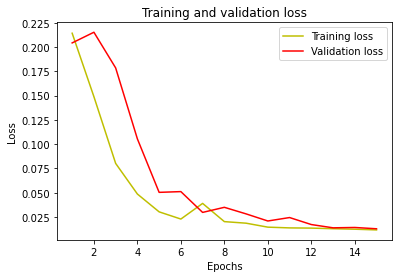

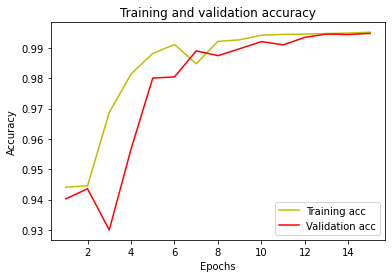

In [28]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
#IOU
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(y_test, y_pred_thresholded)
union = np.logical_or(y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

7/7 [==============================] - 4s 547ms/step
IoU socre is:  0.9148738851456919


1/1 [==============================] - 0s 47ms/step


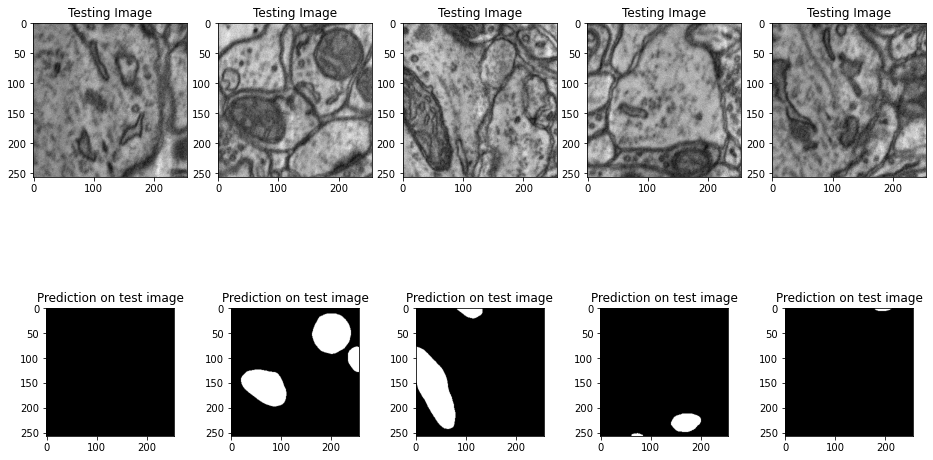

In [60]:
plt.figure(figsize=(16, 8))

num_images = 5  # Number of images to display

for i in range(num_images):
    test_img_number = random.randint(0, len(X_test))
    test_img = X_test[test_img_number]
    ground_truth = y_test[test_img_number]
    test_img_norm = test_img[:, :, 0][:, :, None]
    test_img_input = np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input)[0, :, :, 0] > 0.5).astype(np.uint8)

    plt.subplot(2, num_images, i+1)
    plt.title('Testing Image')
    plt.imshow(test_img[:, :, 0], cmap='gray')

    plt.subplot(2, num_images, num_images + i + 1)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:, :, 0], cmap='gray')

    plt.subplot(3, num_images, num_images * 2 + i + 1)
    plt.title('Prediction on test image')
    plt.imshow(prediction, cmap='gray')

plt.show()


In [61]:
###ok we have trained and tested our model with patches.
###Lets try to validate our model on the validation dataset
###by using the full size images
###we cant because our model has been trained on 256px images
### we will create patches and do the same process on the validation dataset

In [42]:
model.load_weights('mitochondria_small_unet_15_epochs_accuracy_metric.hdf5')

In [43]:
val_image_directory = 'data/patched_validation_images/'
val_mask_directory= 'data/patched_validation_masks/'

In [44]:
val_dataset = []  
val_masks_dataset=[]

In [45]:
val_images = os.listdir(val_image_directory)
for i, image_name in enumerate(val_images):    
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(val_image_directory+image_name, 0)
        image = Image.fromarray(image)
        #image = image.resize((SIZE, SIZE))
        val_dataset.append(np.array(image))

In [46]:
val_masks = os.listdir(val_mask_directory)
for i, image_name in enumerate(val_masks):
    if (image_name.split('.')[1] == 'tif'):
        image = cv2.imread(val_mask_directory+image_name, 0)
        image = Image.fromarray(image)
        #image = image.resize((SIZE, SIZE))
        val_masks_dataset.append(np.array(image))

In [47]:
np.shape(val_dataset)

(1980, 256, 256)

In [48]:
val_dataset_1 = np.expand_dims(normalize(np.array(val_dataset), axis=1),3)

In [49]:
np.shape(val_dataset_1)

(1980, 256, 256, 1)

In [50]:
np.shape(val_masks_dataset)

(1980, 256, 256)

In [51]:
val_masks_dataset_1 = np.expand_dims((np.array(val_masks_dataset)),3) /255.

In [52]:
np.shape(val_masks_dataset_1)

(1980, 256, 256, 1)

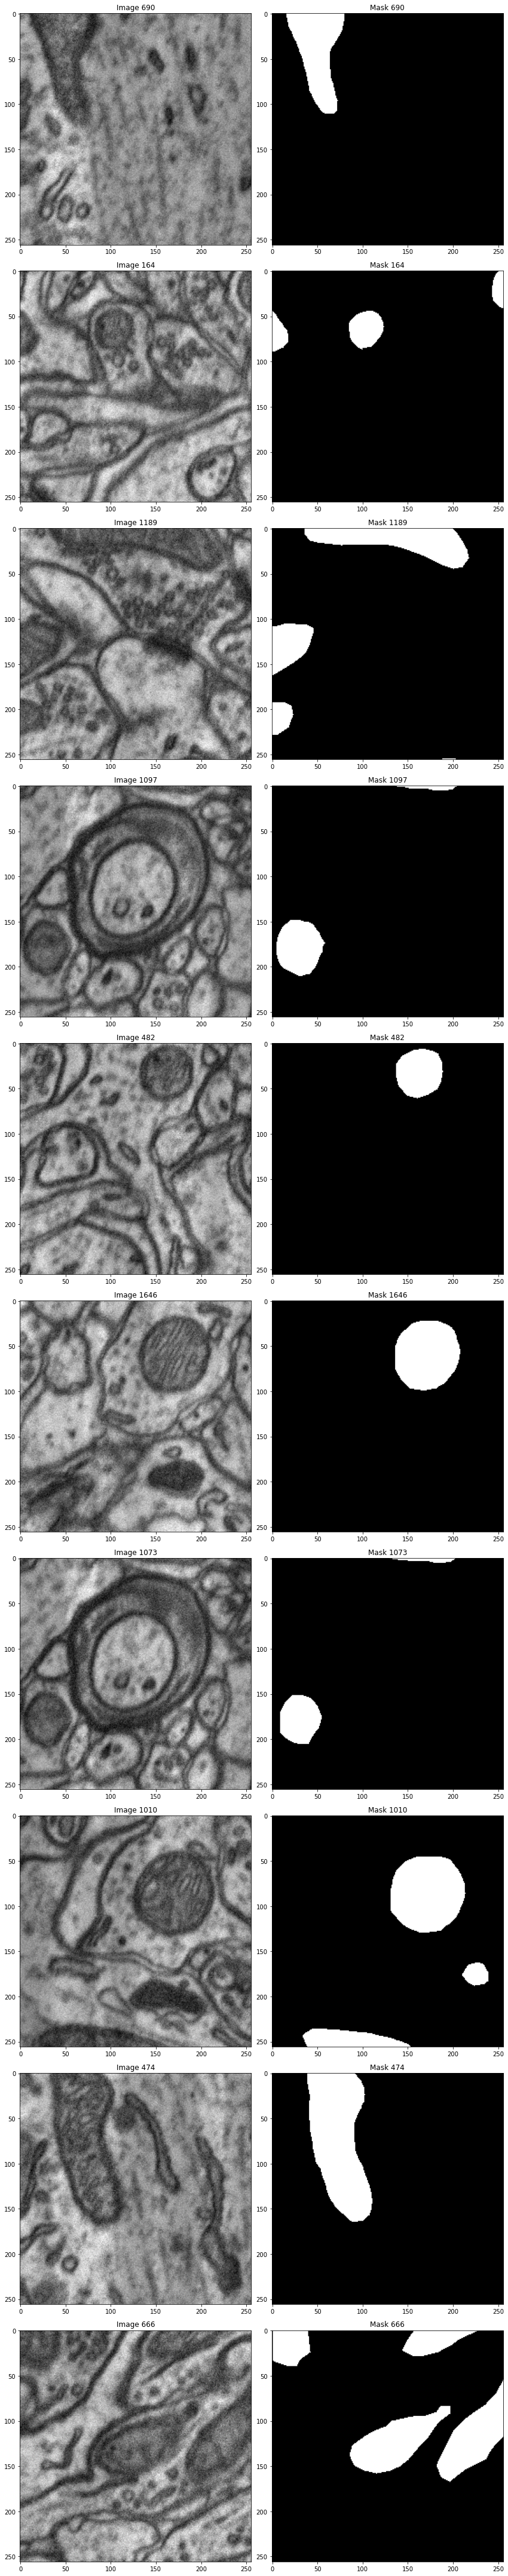

In [53]:
num_images = 10  # Number of images to display

plt.figure(figsize=(12, 6 * num_images))

for i in range(num_images):
    image_number = random.randint(0, len(val_dataset_1))

    plt.subplot(num_images, 2, 2 * i + 1)
    plt.imshow(np.reshape(val_dataset_1[image_number], (256, 256)), cmap='gray')
    plt.title(f'Image {image_number}')

    plt.subplot(num_images, 2, 2 * i + 2)
    plt.imshow(np.reshape(val_masks_dataset_1[image_number], (256, 256)), cmap='gray')
    plt.title(f'Mask {image_number}')

plt.tight_layout()
plt.show()


In [54]:
#IOU
y_pred=model.predict(val_dataset_1)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(val_masks_dataset_1, y_pred_thresholded)
union = np.logical_or(val_masks_dataset_1, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

62/62 [==============================] - 41s 665ms/step
IoU socre is:  0.6494407556155021


In [55]:


# Evaluate the model on the validation dataset
validation_loss, validation_accuracy = model.evaluate(val_dataset_1, val_masks_dataset_1)

# Print the evaluation results
print("Validation Loss: {:.4f}, Validation Accuracy: {:.2f}%".format(validation_loss, validation_accuracy * 100))


62/62 [==============================] - 45s 718ms/step - loss: 0.1104 - accuracy: 0.9784
Validation Loss: 0.1104, Validation Accuracy: 97.84%


In [151]:
y_pred_thresholded.shape

(1980, 256, 256, 1)

In [204]:
import tifffile as tiff
import os

# Path to the TIFF file containing multiple images
tif_file = 'data/val_images/testing.tif'

# Output directory to save the extracted images
output_directory = 'data_val_images_all/'

# Load the TIFF file
multi_image = tiff.imread(tif_file)

# Check the dimensions of the multi-image array
num_images, image_height, image_width = multi_image.shape

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Iterate over the images and save them as separate files
for i in range(num_images):
    # Extract the current image
    image = multi_image[i]

    # Generate the output file path
    output_path = os.path.join(output_directory, f'image_{i+1}.tif')

    # Save the image as a separate file
    tiff.imwrite(output_path, image)

    # Print the saved file path for reference
    print(f'Saved image: {output_path}')


Saved image: data_val_images_all/image_1.tif
Saved image: data_val_images_all/image_2.tif
Saved image: data_val_images_all/image_3.tif
Saved image: data_val_images_all/image_4.tif
Saved image: data_val_images_all/image_5.tif
Saved image: data_val_images_all/image_6.tif
Saved image: data_val_images_all/image_7.tif
Saved image: data_val_images_all/image_8.tif
Saved image: data_val_images_all/image_9.tif
Saved image: data_val_images_all/image_10.tif
Saved image: data_val_images_all/image_11.tif
Saved image: data_val_images_all/image_12.tif
Saved image: data_val_images_all/image_13.tif
Saved image: data_val_images_all/image_14.tif
Saved image: data_val_images_all/image_15.tif
Saved image: data_val_images_all/image_16.tif
Saved image: data_val_images_all/image_17.tif
Saved image: data_val_images_all/image_18.tif
Saved image: data_val_images_all/image_19.tif
Saved image: data_val_images_all/image_20.tif
Saved image: data_val_images_all/image_21.tif
Saved image: data_val_images_all/image_22.t

In [153]:
import os
import cv2
import numpy as np
import tifffile as tiff
from patchify import patchify, unpatchify



# Path to your file containing 165 images
file_path = "data/data_val_images_all"

# Desired patch size
patch_size = (256, 256)

# Create an empty list to store the predicted masks

# Loop through the file
for i in range(1, 166):
    # Load the image
    image_path = f'{file_path}/image_{i}.tif'
    image = cv2.imread(image_path, 0)

    patches = patchify(image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap
    

    predicted_patches = []
    for j in range(patches.shape[0]):
        for k in range(patches.shape[1]):
            print(j,k)
        
            single_patch = patches[j,k,:,:]
            single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1),2)
            single_patch_input=np.expand_dims(single_patch_norm, 0)

        #Predict and threshold for values above 0.5 probability
            single_patch_prediction = (model.predict(single_patch_input)[0,:,:,0] > 0.5).astype(np.uint8)
            predicted_patches.append(single_patch_prediction)

    predicted_patches = np.array(predicted_patches)

    predicted_patches_reshaped = np.reshape(predicted_patches, (patches.shape[0], patches.shape[1], 256,256) )
    reconstructed_image = unpatchify(predicted_patches_reshaped, image.shape)
    
    # Save the predicted mask as an image
    save_path = f'data/final_mask/mask_{i}.jpg'
    plt.imsave(save_path, reconstructed_image, cmap='gray')

0 0
1/1 [==============================] - 0s 240ms/step
0 1
1/1 [==============================] - 0s 252ms/step
0 2
1/1 [==============================] - 0s 246ms/step
0 3
1/1 [==============================] - 0s 240ms/step
1 0
1/1 [==============================] - 0s 245ms/step
1 1
1/1 [==============================] - 0s 249ms/step
1 2
1/1 [==============================] - 0s 250ms/step
1 3
1/1 [==============================] - 0s 254ms/step
2 0
1/1 [==============================] - 0s 244ms/step
2 1
1/1 [==============================] - 0s 251ms/step
2 2
1/1 [==============================] - 0s 239ms/step
2 3
1/1 [==============================] - 0s 256ms/step
0 0
1/1 [==============================] - 0s 250ms/step
0 1
1/1 [==============================] - 0s 254ms/step
0 2
1/1 [==============================] - 0s 245ms/step
0 3
1/1 [==============================] - 0s 253ms/step
1 0
1/1 [==============================] - 0s 255ms/step
1 1
1/1 [======================

1/1 [==============================] - 0s 250ms/step
0 0
1/1 [==============================] - 0s 258ms/step
0 1
1/1 [==============================] - 0s 254ms/step
0 2
1/1 [==============================] - 0s 259ms/step
0 3
1/1 [==============================] - 0s 249ms/step
1 0
1/1 [==============================] - 0s 255ms/step
1 1
1/1 [==============================] - 0s 257ms/step
1 2
1/1 [==============================] - 0s 253ms/step
1 3
1/1 [==============================] - 0s 256ms/step
2 0
1/1 [==============================] - 0s 254ms/step
2 1
1/1 [==============================] - 0s 255ms/step
2 2
1/1 [==============================] - 0s 251ms/step
2 3
1/1 [==============================] - 0s 256ms/step
0 0
1/1 [==============================] - 0s 258ms/step
0 1
1/1 [==============================] - 0s 259ms/step
0 2
1/1 [==============================] - 0s 248ms/step
0 3
1/1 [==============================] - 0s 258ms/step
1 0
1/1 [==========================

1/1 [==============================] - 0s 252ms/step
2 3
1/1 [==============================] - 0s 248ms/step
0 0
1/1 [==============================] - 0s 247ms/step
0 1
1/1 [==============================] - 0s 249ms/step
0 2
1/1 [==============================] - 0s 248ms/step
0 3
1/1 [==============================] - 0s 254ms/step
1 0
1/1 [==============================] - 0s 252ms/step
1 1
1/1 [==============================] - 0s 248ms/step
1 2
1/1 [==============================] - 0s 248ms/step
1 3
1/1 [==============================] - 0s 250ms/step
2 0
1/1 [==============================] - 0s 252ms/step
2 1
1/1 [==============================] - 0s 252ms/step
2 2
1/1 [==============================] - 0s 248ms/step
2 3
1/1 [==============================] - 0s 249ms/step
0 0
1/1 [==============================] - 0s 248ms/step
0 1
1/1 [==============================] - 0s 248ms/step
0 2
1/1 [==============================] - 0s 254ms/step
0 3
1/1 [==========================

1/1 [==============================] - 0s 259ms/step
2 2
1/1 [==============================] - 0s 250ms/step
2 3
1/1 [==============================] - 0s 243ms/step
0 0
1/1 [==============================] - 0s 250ms/step
0 1
1/1 [==============================] - 0s 244ms/step
0 2
1/1 [==============================] - 0s 250ms/step
0 3
1/1 [==============================] - 0s 245ms/step
1 0
1/1 [==============================] - 0s 244ms/step
1 1
1/1 [==============================] - 0s 245ms/step
1 2
1/1 [==============================] - 0s 249ms/step
1 3
1/1 [==============================] - 0s 248ms/step
2 0
1/1 [==============================] - 0s 248ms/step
2 1
1/1 [==============================] - 0s 244ms/step
2 2
1/1 [==============================] - 0s 250ms/step
2 3
1/1 [==============================] - 0s 251ms/step
0 0
1/1 [==============================] - 0s 256ms/step
0 1
1/1 [==============================] - 0s 250ms/step
0 2
1/1 [==========================

1/1 [==============================] - 0s 250ms/step
2 1
1/1 [==============================] - 0s 250ms/step
2 2
1/1 [==============================] - 0s 265ms/step
2 3
1/1 [==============================] - 0s 253ms/step
0 0
1/1 [==============================] - 0s 247ms/step
0 1
1/1 [==============================] - 0s 247ms/step
0 2
1/1 [==============================] - 0s 245ms/step
0 3
1/1 [==============================] - 0s 250ms/step
1 0
1/1 [==============================] - 0s 247ms/step
1 1
1/1 [==============================] - 0s 247ms/step
1 2
1/1 [==============================] - 0s 250ms/step
1 3
1/1 [==============================] - 0s 250ms/step
2 0
1/1 [==============================] - 0s 248ms/step
2 1
1/1 [==============================] - 0s 248ms/step
2 2
1/1 [==============================] - 0s 248ms/step
2 3
1/1 [==============================] - 0s 245ms/step
0 0
1/1 [==============================] - 0s 245ms/step
0 1
1/1 [==========================

1/1 [==============================] - 0s 250ms/step
2 0
1/1 [==============================] - 0s 254ms/step
2 1
1/1 [==============================] - 0s 250ms/step
2 2
1/1 [==============================] - 0s 251ms/step
2 3
1/1 [==============================] - 0s 258ms/step
0 0
1/1 [==============================] - 0s 250ms/step
0 1
1/1 [==============================] - 0s 251ms/step
0 2
1/1 [==============================] - 0s 250ms/step
0 3
1/1 [==============================] - 0s 255ms/step
1 0
1/1 [==============================] - 0s 250ms/step
1 1
1/1 [==============================] - 0s 250ms/step
1 2
1/1 [==============================] - 0s 250ms/step
1 3
1/1 [==============================] - 0s 250ms/step
2 0
1/1 [==============================] - 0s 254ms/step
2 1
1/1 [==============================] - 0s 245ms/step
2 2
1/1 [==============================] - 0s 250ms/step
2 3
1/1 [==============================] - 0s 255ms/step
0 0
1/1 [==========================

1/1 [==============================] - 0s 250ms/step
1 3
1/1 [==============================] - 0s 241ms/step
2 0
1/1 [==============================] - 0s 247ms/step
2 1
1/1 [==============================] - 0s 250ms/step
2 2
1/1 [==============================] - 0s 250ms/step
2 3
1/1 [==============================] - 0s 248ms/step
0 0
1/1 [==============================] - 0s 240ms/step
0 1
1/1 [==============================] - 0s 252ms/step
0 2
1/1 [==============================] - 0s 246ms/step
0 3
1/1 [==============================] - 0s 250ms/step
1 0
1/1 [==============================] - 0s 250ms/step
1 1
1/1 [==============================] - 0s 245ms/step
1 2
1/1 [==============================] - 0s 248ms/step
1 3
1/1 [==============================] - 0s 247ms/step
2 0
1/1 [==============================] - 0s 252ms/step
2 1
1/1 [==============================] - 0s 250ms/step
2 2
1/1 [==============================] - 0s 240ms/step
2 3
1/1 [==========================

1/1 [==============================] - 0s 250ms/step
1 2
1/1 [==============================] - 0s 254ms/step
1 3
1/1 [==============================] - 0s 250ms/step
2 0
1/1 [==============================] - 0s 242ms/step
2 1
1/1 [==============================] - 0s 249ms/step
2 2
1/1 [==============================] - 0s 250ms/step
2 3
1/1 [==============================] - 0s 240ms/step
0 0
1/1 [==============================] - 0s 247ms/step
0 1
1/1 [==============================] - 0s 260ms/step
0 2
1/1 [==============================] - 0s 258ms/step
0 3
1/1 [==============================] - 0s 253ms/step
1 0
1/1 [==============================] - 0s 255ms/step
1 1
1/1 [==============================] - 0s 265ms/step
1 2
1/1 [==============================] - 0s 257ms/step
1 3
1/1 [==============================] - 0s 255ms/step
2 0
1/1 [==============================] - 0s 250ms/step
2 1
1/1 [==============================] - 0s 258ms/step
2 2
1/1 [==========================

1/1 [==============================] - 0s 263ms/step
1 1
1/1 [==============================] - 0s 260ms/step
1 2
1/1 [==============================] - 0s 260ms/step
1 3
1/1 [==============================] - 0s 266ms/step
2 0
1/1 [==============================] - 0s 262ms/step
2 1
1/1 [==============================] - 0s 256ms/step
2 2
1/1 [==============================] - 0s 250ms/step
2 3
1/1 [==============================] - 0s 260ms/step
0 0
1/1 [==============================] - 0s 260ms/step
0 1
1/1 [==============================] - 0s 256ms/step
0 2
1/1 [==============================] - 0s 259ms/step
0 3
1/1 [==============================] - 0s 255ms/step
1 0
1/1 [==============================] - 0s 252ms/step
1 1
1/1 [==============================] - 0s 246ms/step
1 2
1/1 [==============================] - 0s 260ms/step
1 3
1/1 [==============================] - 0s 250ms/step
2 0
1/1 [==============================] - 0s 260ms/step
2 1
1/1 [==========================

1/1 [==============================] - 0s 250ms/step
1 0
1/1 [==============================] - 0s 260ms/step
1 1
1/1 [==============================] - 0s 262ms/step
1 2
1/1 [==============================] - 0s 260ms/step
1 3
1/1 [==============================] - 0s 255ms/step
2 0
1/1 [==============================] - 0s 260ms/step
2 1
1/1 [==============================] - 0s 268ms/step
2 2
1/1 [==============================] - 0s 254ms/step
2 3
1/1 [==============================] - 0s 250ms/step
0 0
1/1 [==============================] - 0s 254ms/step
0 1
1/1 [==============================] - 0s 260ms/step
0 2
1/1 [==============================] - 0s 250ms/step
0 3
1/1 [==============================] - 0s 260ms/step
1 0
1/1 [==============================] - 0s 250ms/step
1 1
1/1 [==============================] - 0s 253ms/step
1 2
1/1 [==============================] - 0s 245ms/step
1 3
1/1 [==============================] - 0s 260ms/step
2 0
1/1 [==========================

1/1 [==============================] - 0s 247ms/step
0 3
1/1 [==============================] - 0s 250ms/step
1 0
1/1 [==============================] - 0s 258ms/step
1 1
1/1 [==============================] - 0s 260ms/step
1 2
1/1 [==============================] - 0s 243ms/step
1 3
1/1 [==============================] - 0s 253ms/step
2 0
1/1 [==============================] - 0s 255ms/step
2 1
1/1 [==============================] - 0s 261ms/step
2 2
1/1 [==============================] - 0s 254ms/step
2 3
1/1 [==============================] - 0s 254ms/step
0 0
1/1 [==============================] - 0s 254ms/step
0 1
1/1 [==============================] - 0s 252ms/step
0 2
1/1 [==============================] - 0s 252ms/step
0 3
1/1 [==============================] - 0s 254ms/step
1 0
1/1 [==============================] - 0s 252ms/step
1 1
1/1 [==============================] - 0s 256ms/step
1 2
1/1 [==============================] - 0s 255ms/step
1 3
1/1 [==========================

1/1 [==============================] - 0s 262ms/step
0 2
1/1 [==============================] - 0s 259ms/step
0 3
1/1 [==============================] - 0s 260ms/step
1 0
1/1 [==============================] - 0s 263ms/step
1 1
1/1 [==============================] - 0s 280ms/step
1 2
1/1 [==============================] - 0s 270ms/step
1 3
1/1 [==============================] - 0s 288ms/step
2 0
1/1 [==============================] - 0s 272ms/step
2 1
1/1 [==============================] - 0s 267ms/step
2 2
1/1 [==============================] - 0s 280ms/step
2 3
1/1 [==============================] - 0s 271ms/step
0 0
1/1 [==============================] - 0s 265ms/step
0 1
1/1 [==============================] - 0s 270ms/step
0 2
1/1 [==============================] - 0s 270ms/step
0 3
1/1 [==============================] - 0s 270ms/step
1 0
1/1 [==============================] - 0s 270ms/step
1 1
1/1 [==============================] - 0s 280ms/step
1 2
1/1 [==========================

1/1 [==============================] - 0s 264ms/step
0 1
1/1 [==============================] - 0s 272ms/step
0 2
1/1 [==============================] - 0s 260ms/step
0 3
1/1 [==============================] - 0s 256ms/step
1 0
1/1 [==============================] - 0s 256ms/step
1 1
1/1 [==============================] - 0s 260ms/step
1 2
1/1 [==============================] - 0s 265ms/step
1 3
1/1 [==============================] - 0s 266ms/step
2 0
1/1 [==============================] - 0s 254ms/step
2 1
1/1 [==============================] - 0s 256ms/step
2 2
1/1 [==============================] - 0s 263ms/step
2 3
1/1 [==============================] - 0s 263ms/step
0 0
1/1 [==============================] - 0s 265ms/step
0 1
1/1 [==============================] - 0s 264ms/step
0 2
1/1 [==============================] - 0s 268ms/step
0 3
1/1 [==============================] - 0s 266ms/step
1 0
1/1 [==============================] - 0s 264ms/step
1 1
1/1 [==========================

1/1 [==============================] - 0s 258ms/step
0 0
1/1 [==============================] - 0s 265ms/step
0 1
1/1 [==============================] - 0s 260ms/step
0 2
1/1 [==============================] - 0s 276ms/step
0 3
1/1 [==============================] - 0s 268ms/step
1 0
1/1 [==============================] - 0s 260ms/step
1 1
1/1 [==============================] - 0s 256ms/step
1 2
1/1 [==============================] - 0s 262ms/step
1 3
1/1 [==============================] - 0s 255ms/step
2 0
1/1 [==============================] - 0s 258ms/step
2 1
1/1 [==============================] - 0s 260ms/step
2 2
1/1 [==============================] - 0s 269ms/step
2 3
1/1 [==============================] - 0s 260ms/step
0 0
1/1 [==============================] - 0s 255ms/step
0 1
1/1 [==============================] - 0s 259ms/step
0 2
1/1 [==============================] - 0s 255ms/step
0 3
1/1 [==============================] - 0s 257ms/step
1 0
1/1 [==========================

In [18]:
from keras import backend as K
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred) 

In [19]:
model.compile(optimizer = 'adam', loss = [jacard_coef_loss], metrics = [jacard_coef])

In [20]:
history2 = model.fit(X_train, y_train, 
                    batch_size = 16, 
                    epochs=15, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

Epoch 1/15
112/112 [==============================] - 292s 3s/step - loss: -0.2728 - jacard_coef: 0.2730 - val_loss: -0.2927 - val_jacard_coef: 0.2964
Epoch 2/15
112/112 [==============================] - 286s 3s/step - loss: -0.6121 - jacard_coef: 0.6117 - val_loss: -0.4907 - val_jacard_coef: 0.5001
Epoch 3/15
112/112 [==============================] - 290s 3s/step - loss: -0.7036 - jacard_coef: 0.7040 - val_loss: -0.6786 - val_jacard_coef: 0.6833
Epoch 4/15
112/112 [==============================] - 285s 3s/step - loss: -0.7672 - jacard_coef: 0.7660 - val_loss: -0.7717 - val_jacard_coef: 0.7739
Epoch 5/15
112/112 [==============================] - 280s 2s/step - loss: -0.7858 - jacard_coef: 0.7861 - val_loss: -0.8342 - val_jacard_coef: 0.8362
Epoch 6/15
112/112 [==============================] - 281s 3s/step - loss: -0.8234 - jacard_coef: 0.8226 - val_loss: -0.8400 - val_jacard_coef: 0.8422
Epoch 7/15
112/112 [==============================] - 286s 3s/step - loss: -0.8389 - jacard_co

In [21]:
model.save('mitochondria_small_unet_15_epochs_iou_metric.hdf5')

In [157]:
model.load_weights('mitochondria_small_unet_15_epochs_iou_metric.hdf5')

In [158]:
#IOU
y_pred=model.predict(val_dataset_1)
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and(val_masks_dataset_1, y_pred_thresholded)
union = np.logical_or(val_masks_dataset_1, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

62/62 [==============================] - 387s 6s/step
IoU socre is:  0.7153221007036786
